In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from scipy.stats.mstats import winsorize

# Reproducibility
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)


2025-12-26 09:08:00.702002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766740080.870993      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766740080.919858      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766740081.290463      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766740081.290496      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766740081.290499      55 computation_placer.cc:177] computation placer alr

In [2]:
def generate_tissue_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def reinhard_np(img):
    """Apply Reinhard normalization"""
    img = img.astype(np.float32)
    mu, sigma = img.mean(), img.std()
    img = (img - mu) / (sigma + 1e-6)
    img = (img * 0.1) + 0.5
    img = np.clip(img, 0, 1)
    return (img * 255).astype(np.uint8)

PATCH_SIZE = 224
STRIDE = 224
TISSUE_THRESHOLD = 0.7

def extract_patches(img, mask, save_dir, slide_id):
    h, w, _ = img.shape
    for y in range(0, h - PATCH_SIZE + 1, STRIDE):
        for x in range(0, w - PATCH_SIZE + 1, STRIDE):
            patch = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            mask_patch = mask[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            tissue_ratio = np.sum(mask_patch > 0) / (PATCH_SIZE*PATCH_SIZE)
            if tissue_ratio >= TISSUE_THRESHOLD:
                patch_name = f"{slide_id}_x{x}_y{y}.png"
                cv2.imwrite(os.path.join(save_dir, patch_name), patch)

def process_wsi(image_path, label_name, output_root):
    slide_id = os.path.splitext(os.path.basename(image_path))[0]
    img = cv2.imread(image_path)
    mask = generate_tissue_mask(img)
    save_dir = os.path.join(output_root, label_name)
    os.makedirs(save_dir, exist_ok=True)
    extract_patches(img, mask, save_dir, slide_id)


In [3]:
DATASET_ROOT = "/kaggle/input/her2-sish-dataset"
PATCH_ROOT = "/kaggle/working/patches"
classes = {
    "Amplified Samples": "Amplified",
    "Non-Amplified Samples": "Non_Amplified",
    "ROI_Normal": "ROI_Normal"
}

# Extract patches for all WSIs
for folder, label in classes.items():
    folder_path = os.path.join(DATASET_ROOT, folder)
    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith((".png",".jpg")):
            process_wsi(os.path.join(folder_path,img_name), label, PATCH_ROOT)


In [4]:
BATCH_SIZE = 16
IMG_SIZE = (224,224)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.25),
    layers.GaussianNoise(0.05),
])

# Raw datasets
raw_train_ds = image_dataset_from_directory(
    PATCH_ROOT,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)
raw_temp_ds = image_dataset_from_directory(
    PATCH_ROOT,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

# Store class names before caching
class_names = raw_train_ds.class_names
print("Class names:", class_names)

# Split temp into val + test
temp_batches = tf.data.experimental.cardinality(raw_temp_ds).numpy()
val_batches = temp_batches // 2
test_batches = temp_batches - val_batches
val_ds = raw_temp_ds.take(val_batches)
test_ds = raw_temp_ds.skip(val_batches)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

# Compute class weights
y_train = []
for _, labels in raw_train_ds:
    y_train.extend(labels.numpy())
y_train = np.array(y_train)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Found 1700 files belonging to 3 classes.
Using 1190 files for training.


I0000 00:00:1766740525.859400      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1700 files belonging to 3 classes.
Using 510 files for validation.
Class names: ['Amplified', 'Non_Amplified', 'ROI_Normal']
Class weights: {0: np.float64(0.8078750848608283), 1: np.float64(0.7933333333333333), 2: np.float64(1.9932998324958124)}


In [5]:
def _iso_winsor_numpy_flat(x_batch_np, contamination=0.05, win_limit=0.05, random_state=42):
    if hasattr(x_batch_np,"numpy"):
        x_batch_np = x_batch_np.numpy()
    x_batch_np = np.asarray(x_batch_np, dtype=np.float32)
    B,F = x_batch_np.shape
    clf = IsolationForest(contamination=contamination, random_state=random_state)
    preds = clf.fit_predict(x_batch_np)
    out = x_batch_np.copy()
    for i in range(B):
        if preds[i]==-1:
            w = winsorize(out[i], limits=[win_limit, win_limit])
            out[i] = np.asarray(w,dtype=np.float32)
    return out

def isolation_winsor_flattened_tf(contamination=0.05, win_limit=0.05, random_state=42):
    def layer_op(x2d):
        @tf.custom_gradient
        def _op(x_in):
            y = tf.py_function(
                func=lambda z: _iso_winsor_numpy_flat(
                    z, contamination=contamination, win_limit=win_limit, random_state=random_state
                ),
                inp=[x_in],
                Tout=tf.float32
            )
            y.set_shape(x_in.shape)
            def grad(dy): return dy
            return y, grad
        return _op(x2d)
    return layer_op


In [6]:
def build_vgg19_vit_hybrid(input_shape=(224,224,3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Augmentation + Rescaling
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # CNN (VGG19)
    vgg = VGG19(include_top=False, weights="imagenet", input_tensor=x)
    vgg.trainable = False
    cnn_feat = layers.GlobalAveragePooling2D()(vgg.output)

    # Isolation Forest Lambda
    cnn_feat = layers.Lambda(
        isolation_winsor_flattened_tf(contamination=0.05, win_limit=0.05),
        name="cnn_robust"
    )(cnn_feat)

    # ViT Attention
    tokens = layers.Reshape((1, cnn_feat.shape[-1]))(cnn_feat)
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=cnn_feat.shape[-1]//4)(tokens, tokens)
    attn = layers.Flatten()(attn)

    # Fusion + Classifier
    fused = layers.Concatenate()([cnn_feat, attn])
    fused = layers.Dense(256, activation="relu")(fused)
    fused = layers.Dropout(0.3)(fused)
    fused = layers.Dense(128, activation="relu")(fused)
    outputs = layers.Dense(num_classes, activation="softmax")(fused)

    return models.Model(inputs, outputs)

model = build_vgg19_vit_hybrid(input_shape=(224,224,3), num_classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ rescaling[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 56, 56,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][

 Total params: 21,370,691 (81.52 MB)

 Trainable params: 1,346,307 (5.14 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [7]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6)
]

# Phase 1: Freeze VGG19
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

# Phase 2: Fine-tune last VGG19 block
for layer in model.layers:
    if "block5" in layer.name:
        layer.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
fine_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/30


I0000 00:00:1766740561.945795     125 cuda_dnn.cc:529] Loaded cuDNN version 91002


75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 261ms/step - accuracy: 0.3737 - loss: 1.0946 - val_accuracy: 0.5039 - val_loss: 0.9771 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - accuracy: 0.4573 - loss: 0.9983 - val_accuracy: 0.5469 - val_loss: 0.8708 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - accuracy: 0.5439 - loss: 0.9046 - val_accuracy: 0.4336 - val_loss: 0.9776 - learning_rate: 1.0000e-04
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.5322 - loss: 0.9170 - val_accuracy: 0.4922 - val_loss: 0.9905 - learning_rate: 1.0000e-04
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.5898 - loss: 0.8853 - val_accuracy: 0.5703 - val_loss: 0.8490 - learning_rate: 1.0000e-04
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.5761 - loss: 0.8606 - val_accuracy: 0.6250 - val_loss: 0.8362 - learning_rate: 1.0000e-04
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.54

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


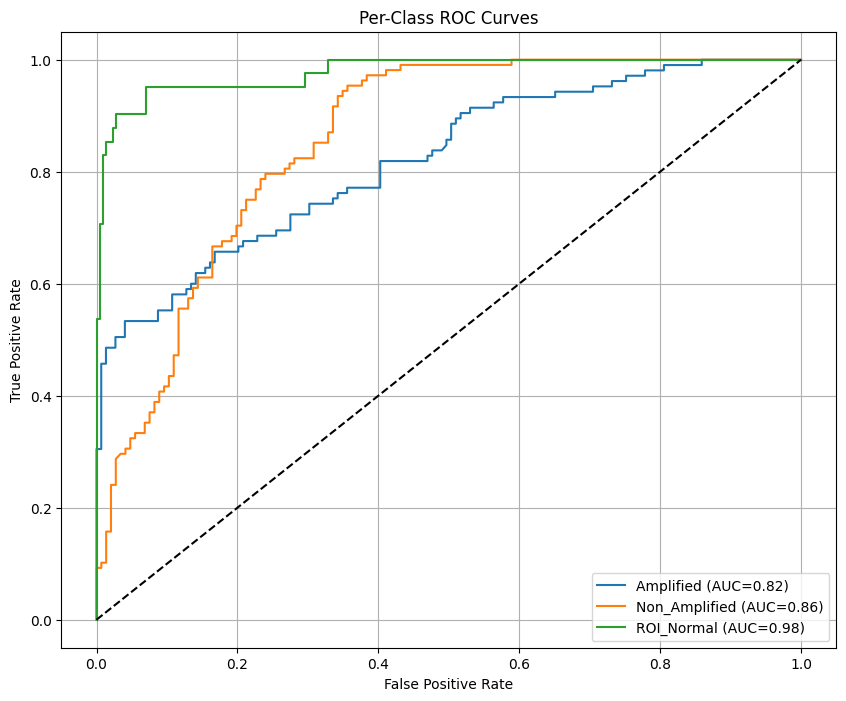

               precision    recall  f1-score   support

    Amplified       0.66      0.69      0.67       105
Non_Amplified       0.70      0.65      0.67       108
   ROI_Normal       0.82      0.90      0.86        41

     accuracy                           0.70       254
    macro avg       0.73      0.75      0.74       254
 weighted avg       0.70      0.70      0.70       254



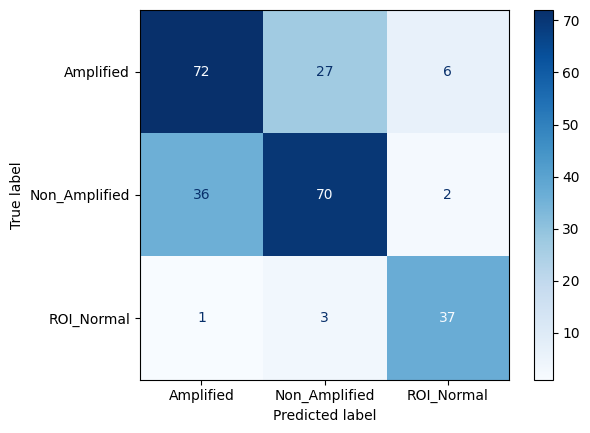

In [8]:
y_true, y_pred_probs = [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
n_classes = y_pred_probs.shape[1]

# ROC-AUC
plt.figure(figsize=(10,8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true==(i), y_pred_probs[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Per-Class ROC Curves")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


In [9]:
# Extract attention weights
attention_layer = [l for l in model.layers if "multi_head_attention" in l.name][0]

for images, labels in test_ds.take(1):
    attn_out, attn_weights = attention_layer(images, return_attention_scores=True)
    attn_map = tf.reduce_mean(attn_weights, axis=1).numpy()  # average heads
    plt.imshow(attn_map[0], cmap="jet")
    plt.title("ViT Attention Map")
    plt.axis("off")
    plt.show()


TypeError: missing a required argument: 'value'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for a given image and model.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradient of top predicted class w.r.t conv output
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-6)
    return heatmap.numpy()


In [ ]:
def overlay_gradcam(img, heatmap, alpha=0.4, colormap=plt.cm.jet):
    """
    Overlay Grad-CAM heatmap on original image.
    """
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = colormap(heatmap)
    heatmap = np.uint8(255*heatmap[..., :3])
    overlay = cv2.addWeighted(img.astype(np.uint8), 1-alpha, heatmap, alpha, 0)
    return overlay


In [ ]:
# Choose last convolution layer in VGG19
last_conv_layer_name = "block5_conv4"

for images, labels in test_ds.take(1):
    # Take first patch from batch
    img = images[0].numpy().astype(np.uint8)
    img_input = np.expand_dims(img, axis=0)
    
    heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)
    overlay = overlay_gradcam(img, heatmap)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Original Patch")
    plt.imshow(img)
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.title("Grad-CAM Overlay")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()
